In [ ]:
!pip install transformers tokenizers evaluate huggingface_hub --quiet

import numpy as np
from huggingface_hub import notebook_login
# notebook_login()

# Loading Model and Tokenizer

In [ ]:
from transformers import TFAutoModelForSequenceClassification, PreTrainedTokenizerFast
import datasets

tokenizer = PreTrainedTokenizerFast.from_pretrained('raygx/GPT2-Nepali-Casual-LM')
tokenizer

PreTrainedTokenizerFast(name_or_path='raygx/GPT2-Nepali-Casual-LM', vocab_size=50000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'pad_token': '[PAD]'}, clean_up_tokenization_spaces=True)

In [ ]:
from transformers import AutoConfig
from transformers import BertTokenizerFast

# print("Loading Model 'distilgpt2")
# using = 'gpt'
# model = TFAutoModelForSequenceClassification.from_pretrained('distilgpt2',
#                                     bos_token_id=tokenizer.bos_token_id,
#                                     eos_token_id=tokenizer.eos_token_id,
#                                     pad_token_id=tokenizer.pad_token_id,
#                                     id2label={0:"NEUTRAL",1:"POSITIVE",2:"NEGATIVE"},
#                                     label2id={"NEUTRAL":0,"POSITIVE":1,"NEGATIVE":2})

  
print("Loading Model 'distilbert-base-uncased")
using = 'bert'
model = TFAutoModelForSequenceClassification.from_config(
    AutoConfig.from_pretrained(
        'distilbert-base-uncased',
        bos_token_id=tokenizer.bos_token_id,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
        id2label={0:"NEUTRAL",1:"POSITIVE",2:"NEGATIVE"},
        label2id={"NEUTRAL":0,"POSITIVE":1,"NEGATIVE":2}
      )
    )

if using == 'bert':
  tokenizer = BertTokenizerFast.from_pretrained("raygx/GPT2-Nepali-Casual-LM")
  
model.resize_token_embeddings(len(tokenizer))
print(model.config)
print(model.summary())

Loading Model 'distilbert-base-uncased


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'PreTrainedTokenizerFast'. 
The class this function is called from is 'BertTokenizerFast'.


DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 1,
  "dim": 768,
  "dropout": 0.1,
  "eos_token_id": 2,
  "hidden_dim": 3072,
  "id2label": {
    "0": "NEUTRAL",
    "1": "POSITIVE",
    "2": "NEGATIVE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NEGATIVE": 2,
    "NEUTRAL": 0,
    "POSITIVE": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 3,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.29.2",
  "vocab_size": 50000
}

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 81321984  
 nLaye

In [ ]:
from transformers import create_optimizer, AdamWeightDecay
import tensorflow as tf

optimizer = AdamWeightDecay(learning_rate=9e-6, weight_decay_rate=0.009)
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


# Data Loading and Preparation

In [ ]:
data = datasets.load_dataset("raygx/NepCov19Tweets")
data = data.rename_columns({"Sentiment":"labels","Sentences":"text"})
data

  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 33471
    })
})

In [ ]:
data = data.shuffle(999)
data = data['train'].train_test_split(test_size=0.1)
data

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 30123
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 3348
    })
})

In [ ]:
def prepareLabels(row):
    if row['labels'] == -1:
        row['labels'] = 2
        
    return row

data = data.map(
        prepareLabels,
        num_proc=4)

print(data)

Map (num_proc=4):   0%|          | 0/30123 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/3348 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 30123
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 3348
    })
})


In [ ]:
%%time

def preprocess_function(rows):
    return tokenizer(rows['text'],truncation=True)

print("Tokenizing the data")
tokenized_inputs = data.map(
    preprocess_function,
    batched=True,
    num_proc=2,
    remove_columns=data["train"].column_names,
)
tokenized_inputs = tokenized_inputs.remove_columns(['token_type_ids'])

tokenized_inputs['train'] = tokenized_inputs['train'].add_column(
    name="labels",column=data['train']['labels']
)
tokenized_inputs['test'] = tokenized_inputs['test'].add_column(
    name="labels",column=data['test']['labels']
)

tokenized_inputs

Tokenizing the data


Map (num_proc=2):   0%|          | 0/30123 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map (num_proc=2):   0%|          | 0/3348 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


CPU times: user 486 ms, sys: 268 ms, total: 754 ms
Wall time: 7.43 s


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 30123
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3348
    })
})

In [ ]:
print(data['train'][:1])
print(tokenized_inputs['train'][:1]['input_ids'])
print(tokenizer.batch_decode(tokenized_inputs['train'][:1]['input_ids']))

{'labels': [0], 'text': ['कोभिड उपचारमा प्रभावकारी केही एन्टिभाइरलका लागि अनुमति दिने प्रक्रियामा छौँ']}
[[1752, 6676, 2913, 623, 11791, 3709, 169, 2242, 352, 3046, 935, 4893, 3179]]
['कोभिड उपचारमा प्रभावकारी केही एन्टिभाइरलका लागि अनुमति दिने प्रक्रियामा छौँ']


In [ ]:
from transformers import DataCollatorWithPadding

print("Initializing Data Collator")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, 
                                        max_length=128,
                                        return_tensors="tf")

Initializing Data Collator


In [ ]:
print("Preparing Training and Testing sets to TRAIN the MODEL")
tf_train_set = model.prepare_tf_dataset(
    tokenized_inputs["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    tokenized_inputs["test"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Preparing Training and Testing sets to TRAIN the MODEL


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


# Training and Evaluation

## Training **Batch 1**

In [ ]:
%%time

n_epoch = 10
print("Training the model")
history = model.fit(x=tf_train_set, 
          validation_data=tf_test_set,
          epochs=n_epoch)
print(history.history)

Training the model
Epoch 1/10
1882/1882 [==============================] - 242s 118ms/step - loss: 0.8216 - val_loss: 0.7592
Epoch 2/10
1882/1882 [==============================] - 219s 116ms/step - loss: 0.6454 - val_loss: 0.7003
Epoch 3/10
1882/1882 [==============================] - 219s 117ms/step - loss: 0.5415 - val_loss: 0.6917
Epoch 4/10
1882/1882 [==============================] - 218s 116ms/step - loss: 0.4486 - val_loss: 0.7233
Epoch 5/10
1882/1882 [==============================] - 219s 116ms/step - loss: 0.3751 - val_loss: 0.7820
Epoch 6/10
1882/1882 [==============================] - 220s 117ms/step - loss: 0.3112 - val_loss: 0.8106
Epoch 7/10
1882/1882 [==============================] - 219s 116ms/step - loss: 0.2579 - val_loss: 0.9428
Epoch 8/10
1882/1882 [==============================] - 220s 117ms/step - loss: 0.2097 - val_loss: 1.1226
Epoch 9/10
1882/1882 [==============================] - 223s 119ms/step - loss: 0.1738 - val_loss: 1.2103
Epoch 10/10
1882/1882 [====

<Axes: >

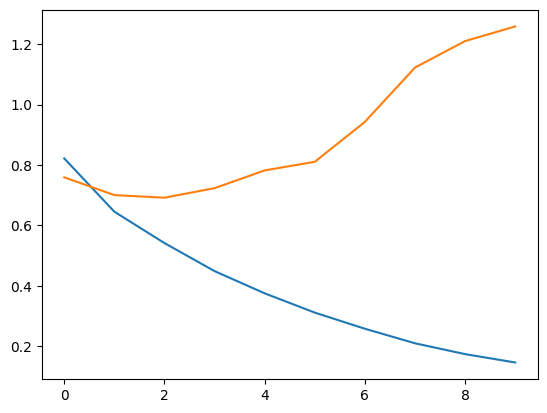

In [ ]:
import seaborn

seaborn.lineplot(history.history['loss'])
seaborn.lineplot(history.history['val_loss'])

### Evaluation

In [ ]:
%%time
from transformers import pipeline, TextClassificationPipeline

if using=='gpt':
  print("Getting Test Prediction")
  pipe = pipeline('sentiment-analysis',model=model,tokenizer=tokenizer)
  prediction = pipe(data['test']['text'])

  print("Prediction Label to Id")
  pred_labels = [model.config.label2id[x['label']] for x in prediction]
else:  
  print("Getting Test Prediction")
  pred_labels = [np.argmax(tf.nn.softmax(model(tf.constant(x)).logits)) for x in tokenized_inputs['test']['input_ids']]

actual_labels = data['test']['labels']

[2, 2, 2, 0, 2, 2, 0, 2, 2, 1, 1, 1, 0, 1, 2, 0, 1, 1, 2, 1, 2, 0, 2, 1, 0, 1, 0, 1, 1, 1, 0, 1, 2, 0, 2, 1, 2, 0, 1, 2, 2, 0, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 0, 0, 0, 2, 1, 2, 2, 1, 2, 2, 0, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 0, 2, 2, 2, 1, 1, 2, 1, 0, 0, 2, 1, 1, 2, 0, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 0, 0, 2, 2, 2, 0, 2, 1, 1, 0, 0, 0, 1, 2, 2, 1, 1, 0, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 0, 2, 2, 1, 1, 1, 0, 1, 0, 2, 2, 1, 1, 1, 0, 0, 0, 1, 1, 0, 2, 1, 2, 1, 1, 1, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 1, 0, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 0, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 0, 1, 1, 2, 2, 1, 0, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 0, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 0, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 0, 2, 1, 1, 1, 0, 1, 0, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 0, 1, 0, 1, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 0, 1, 1, 

**Computing F1-Score, Precision, Recall and Accuracy of the Model**

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

print("F1-Score",f1_score(actual_labels,pred_labels,average='weighted'))
print("Precision-Score",precision_score(actual_labels,pred_labels,average='weighted'))
print("Recall-Score",recall_score(actual_labels,pred_labels,average='weighted'))
print("accuracy_Score",accuracy_score(actual_labels,pred_labels))

F1-Score 0.6898669583521841
Precision-Score 0.6968156381754053
Recall-Score 0.6887694145758662
accuracy_Score 0.6887694145758662


**Plotting Confusion Matrix**

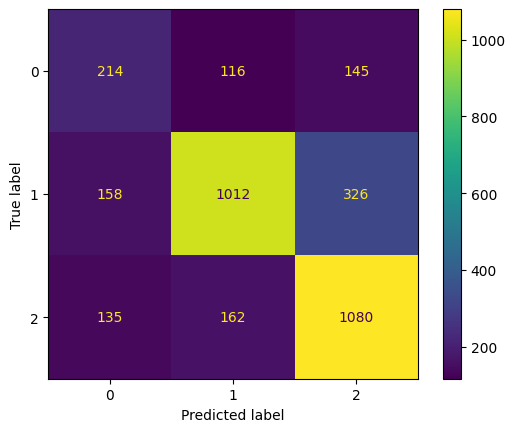

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cmd = ConfusionMatrixDisplay(tf.math.confusion_matrix(actual_labels,pred_labels,num_classes=3).numpy())
cmd.plot()

**Pushing Model to Huggingface Hub**

In [ ]:
### Pushing Model to hub
model.push_to_hub("raygx/GPT2-NepSA-T1",commit_message="Training From Scratch:Distilgpt2;3L6H:Batch 1:Epoch 10",)

## Training **Batch 2**

In [ ]:
%%time
n_epoch = 5 # I've actually run this twice, so it is 10 epochs
print("Training the model")
history = model.fit(x=tf_train_set, 
          validation_data=tf_test_set,
          epochs=n_epoch)
print(history.history)

Training the model
Epoch 1/5
   1/1882 [..............................] - ETA: 5:52 - loss: 0.0197

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


1882/1882 [==============================] - 222s 118ms/step - loss: 0.0551 - val_loss: 1.7056
Epoch 2/5
1882/1882 [==============================] - 225s 120ms/step - loss: 0.0489 - val_loss: 1.7997
Epoch 3/5
1882/1882 [==============================] - 221s 118ms/step - loss: 0.0452 - val_loss: 1.7263
Epoch 4/5
1882/1882 [==============================] - 222s 118ms/step - loss: 0.0385 - val_loss: 1.8973
Epoch 5/5
1882/1882 [==============================] - 224s 119ms/step - loss: 0.0357 - val_loss: 1.9011
{'loss': [0.055088091641664505, 0.04892893508076668, 0.045164555311203, 0.03852160647511482, 0.035661980509757996], 'val_loss': [1.7055646181106567, 1.7996761798858643, 1.7262531518936157, 1.8973119258880615, 1.90109384059906]}
CPU times: user 15min 36s, sys: 34.8 s, total: 16min 11s
Wall time: 19min 51s


<Axes: >

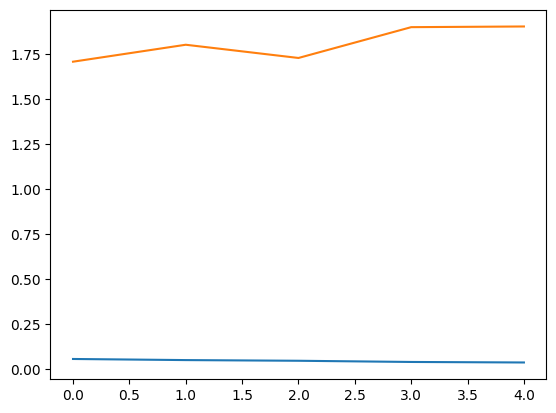

In [ ]:
import seaborn

seaborn.lineplot(history.history['loss'])
seaborn.lineplot(history.history['val_loss'])

### Evaluation

In [ ]:
%%time
from transformers import pipeline, TextClassificationPipeline

if using=='gpt':
  print("Getting Test Prediction")
  pipe = pipeline('sentiment-analysis',model=model,tokenizer=tokenizer)
  prediction = pipe(data['test']['text'])

  print("Prediction Label to Id")
  pred_labels = [model.config.label2id[x['label']] for x in prediction]
else:  
  print("Getting Test Prediction")
  pred_labels = [np.argmax(tf.nn.softmax(model(tf.constant(x)).logits)) for x in tokenized_inputs['test']['input_ids']]

actual_labels = data['test']['labels']

Getting Test Prediction
CPU times: user 6min 8s, sys: 1.4 s, total: 6min 9s
Wall time: 6min 10s


**Computing F1-Score, Precision, Recall and Accuracy of the Model**

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

print("F1-Score",f1_score(actual_labels,pred_labels,average='weighted'))
print("Precision-Score",precision_score(actual_labels,pred_labels,average='weighted'))
print("Recall-Score",recall_score(actual_labels,pred_labels,average='weighted'))
print("accuracy_Score",accuracy_score(actual_labels,pred_labels))

F1-Score 0.6836603053907604
Precision-Score 0.6811617319268835
Recall-Score 0.6893667861409797
accuracy_Score 0.6893667861409797


**Plotting Confusion Matrix**

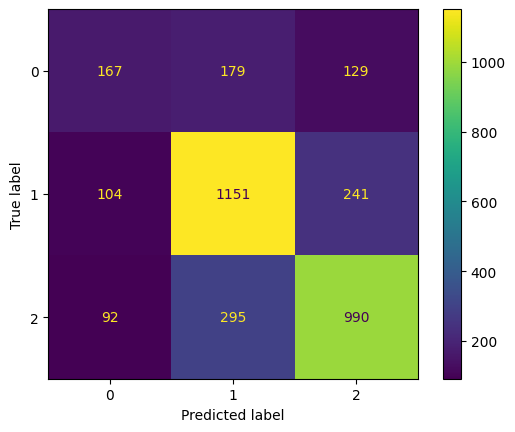

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cmd = ConfusionMatrixDisplay(tf.math.confusion_matrix(actual_labels,pred_labels,num_classes=3).numpy())
cmd.plot()

**Pushing Model to Huggingface Hub**

In [ ]:
# tokenizer.push_to_hub("raygx/GPT2-NepSA-T1")

In [ ]:
### Pushing Model to hub
# model.push_to_hub("raygx/GPT2-NepSA-T1",commit_message="Training From Scratch:Distilgpt2;3L6H:Batch 2:Epoch 5")